# Modelling I – fitting logistic regression on HomeCredit data

This notebook contains an example of fitting and evaluating logistic regression model for the lecture Modelling I.

## Data

We use the basic dataset of clients *application_train.csv*.

* target (default = did not repay the loan)
* loan type
* sex, age, family status, count of children and family members
* ownership of car, realty, income type
* 3 external scores

In [78]:
# setup
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np
import seaborn as sns

pd.set_option("display.precision", 2)

In [79]:
# Home Credit data reading and preparing (a little)
df_hc = pd.read_csv('application_train.csv') # adjust file path
df_hc.columns = df_hc.columns.str.lower()

# data reduction - selection of columns
df_hc_colnames = ['sk_id_curr', 'target', 'name_contract_type', 'code_gender', 'flag_own_car',
                 'flag_own_realty', 'name_income_type', 'days_birth', 'ext_source_1',
                 'ext_source_2', 'ext_source_3', 'cnt_children', 'cnt_fam_members', 'name_family_status']
df_hc = df_hc[df_hc_colnames]
# and renaming to simpler names
df_hc_colnames_new = ['id', 'target', 'loan_type', 'sex', 'has_car',
                 'has_realty', 'income_type', 'age_days', 'score1',
                 'score2', 'score3', 'cnt_children', 'cnt_fam_members', 'fam_status']
df_hc.columns = df_hc_colnames_new

# data transformation
df_hc['age_days'] = -df_hc['age_days']
df_hc['age'] = df_hc['age_days'] / 365.25

## Logistic regression
We take *target* as target and *score2* (and later *sex* and *age*) as predictor(s).

In [80]:
# data preparation
df_hc = df_hc[df_hc['target'].notna() & df_hc['score2'].notna() & df_hc['sex'].notna() & df_hc['age'].notna()]
df_hc = df_hc[df_hc['sex']!='XNA']

In [81]:
print('Target positive rate: ', np.mean(df_hc['target']))

Target positive rate:  0.08073404660954808


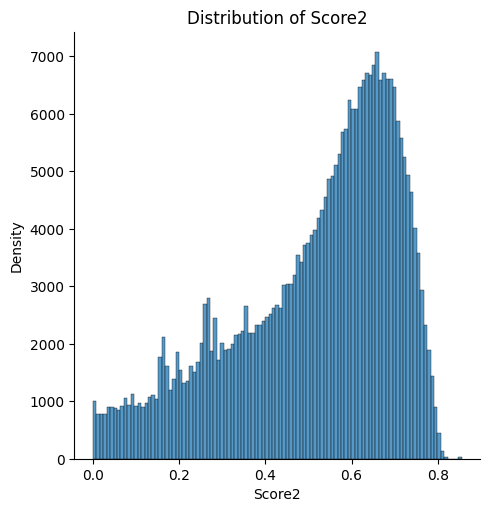

In [82]:
# chart of score2
g = sns.displot(data=df_hc, x="score2") \
    .set_axis_labels("Score2", "Density") \
    .set(title="Distribution of Score2")

In [83]:
### let's go modelling
X = df_hc[['score2']]
y = df_hc['target']

# fit model
modelA = LogisticRegression(solver='newton-cg', penalty='none').fit(X, y)

# get coefficients
print('Intercept: ', modelA.intercept_)
print('Beta coefficients: ', modelA.coef_)

Intercept:  [-1.1484502]
Beta coefficients:  [[-2.73257785]]


c:\Users\vojta\UK\22-23_W\data-science\NDBI048-data-science\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


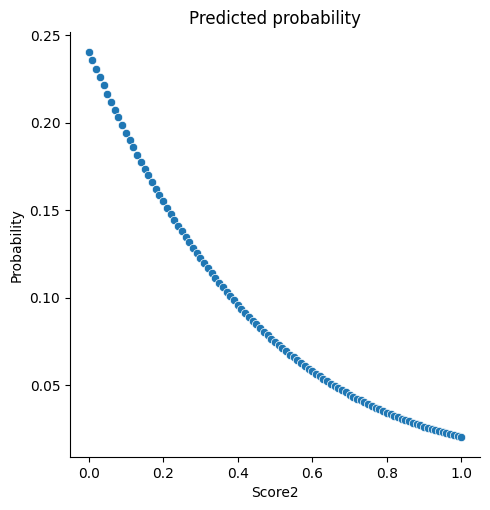

In [84]:
# chart of fitted positive rate vs. score
hlp_x = np.array(range(101)) / 100.0 # fitting for score from 0 to 1
hlp_x2 = [[x] for x in hlp_x.tolist()]
hlp_y = modelA.predict_proba(hlp_x2) # fitted probabilities
hlp_y = [x[1] for x in hlp_y] # transformation to a list
hlp_x2 = [x[0] for x in hlp_x2] # unlisting the list
hlp_df = pd.DataFrame({'score2': hlp_x2, 'pred': hlp_y}) # auxilliary DataFrame for seaborn

g = sns.relplot(data=hlp_df, x="score2", y="pred") \
    .set_axis_labels("Score2", "Probability") \
    .set(title="Predicted probability")

After fitting the model, let's evaluate the performance.

We can compare fitted vs. actual target values on all records, but this is not recommended -- it overrates the model. The correct way is to do **cross-validation**.

The **metric** use by default in sklearn LogisticRegression is **accuracy**. It's not good in unbalanced situations like here:
* it uses prediction threshold 0.5 when we work with small (or big) probabilities;
* predicting all negative or all positive gives high accuracy

In [85]:
### now evaluate model
# assess model performance
# i. scoring itself directly
print('Accuracy on itself: ', modelA.score(X, y))
# Bad for two reasons:
# 1. generally overestimates the performance
# 2. if the target is highly unbalanced, accuracy is bad matric

# ii. scoring by a cross-validation
# but use smarter metric instead of accuracy - e. g. ROC AUC
scores = cross_val_score(LogisticRegression(solver='newton-cg', penalty='none'), X, y, cv=5,
                         scoring='roc_auc')
print('ROC AUC by cval: ', scores)

Accuracy on itself:  0.9192659533904519
ROC AUC by cval:  [0.6549186  0.65767234 0.65557735 0.6555072  0.65695825]


It looks like *score2* makes our model much better than null model. The ROC AUC is about 0.65 (null model gives 0.5).

We can assure ourselves in the significance of *score2* predictor by other view provided by `statmodels` package.

In [86]:
modelC = smf.logit("target ~ score2", data=df_hc).fit()
print(modelC.summary()) # detailed information of model and coefficients

Optimization terminated successfully.
         Current function value: 0.268808
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               306847
Model:                          Logit   Df Residuals:                   306845
Method:                           MLE   Df Model:                            1
Date:                Wed, 23 Nov 2022   Pseudo R-squ.:                 0.04188
Time:                        11:43:03   Log-Likelihood:                -82483.
converged:                       True   LL-Null:                       -86089.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1485      0.015    -76.396      0.000      -1.178      -1.119
score2        -2.7326      0.

> The coefficient at *score2* has p-value much lower than 0.05 threshold, therefore it is significantly different from zero and statistically significant.

Now we add two predictors more: *sex* and *age*.

In [87]:
# data preparation
# it's necessary to make dummies for categorical predictor "sex"
df_hc['sex_orig'] = df_hc['sex'] # backup of the original column - it will be lost!
df_hc = pd.get_dummies(df_hc, columns=['sex'], drop_first=True)
df_hc.rename(columns = {'sex_orig':'sex'}, inplace = True)

In [88]:
X = df_hc[['score2', 'age', 'sex_M']]
y = df_hc['target']

# fit model
modelA = LogisticRegression(solver='newton-cg', penalty='none').fit(X, y)

# get coefficients
print('Intercept: ', modelA.intercept_)
print('Beta coefficients: ', modelA.coef_)

Intercept:  [-0.5443932]
Beta coefficients:  [[-2.63940391 -0.01822577  0.33163506]]


In [89]:
scores = cross_val_score(LogisticRegression(solver='newton-cg', penalty='none'), X, y, cv=5,
                         scoring='roc_auc')
print('ROC AUC by cval: ', scores)

ROC AUC by cval:  [0.6719659  0.67437915 0.67345762 0.67108359 0.67301533]


As we can see, the model performance has slightly increased (0.65 -> 0.67). Is the model with three predictors significantly better than the former model? It seems so, but we can judge it by p-values at coefficients for *age* and *sex*. 

In [90]:
modelC = smf.logit("target ~ score2 + age + sex_M", data=df_hc).fit()
print(modelC.summary()) # detailed information of model and coefficients

Optimization terminated successfully.
         Current function value: 0.265785
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               306847
Model:                          Logit   Df Residuals:                   306843
Method:                           MLE   Df Model:                            3
Date:                Wed, 23 Nov 2022   Pseudo R-squ.:                 0.05266
Time:                        11:43:12   Log-Likelihood:                -81555.
converged:                       True   LL-Null:                       -86089.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5444      0.029    -19.098      0.000      -0.600      -0.489
score2        -2.6394      0.

> Again, all coefficients at predictors are statistically significant -- different from zero.

We can compare predicted and actual values. It should be made on predictions from cross-validation, but just for illustration, let's do it on predictions from model itself.

In [91]:
X_pred = df_hc.sample(50)[['target', 'score2', 'age', 'sex_M']]
y_pred = modelC.predict(X_pred) # fitted probabilities
y_act = X_pred[['target']] # actual target values
y_act['pred'] = y_pred
y_act

C:\Users\vojta\AppData\Local\Temp\ipykernel_17776\4198819969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_act['pred'] = y_pred


,target,pred
115408,0,0.07
107943,0,0.06
74517,0,0.03
27065,0,0.04
234421,0,0.06
24428,0,0.06
144696,0,0.19
67202,0,0.10
183377,0,0.09
44677,0,0.03


As we can see, all predicted probabilites are below 0.5. So for applying any smart metric, one have to put the threshold lower than 0.5. Let's try threshold 0.15 and show the confusion matrix.

In [92]:
from sklearn.metrics import confusion_matrix
y_class = (y_pred > 0.15)
confusion_matrix(y_act['target'], y_class)

array([[47,  2],
       [ 1,  0]], dtype=int64)

## Try it yourself
Now try to use another columns as predictors and to improve risk model. Consider binning some numeric columns to categories.

In [93]:
string_columns = ['loan_type','has_car','has_realty','income_type','fam_status', 'sex']
df_hc = pd.get_dummies(df_hc, columns=string_columns).fillna(0)
df_hc

,id,target,age_days,score1,score2,score3,cnt_children,cnt_fam_members,age,sex_M,...,income_type_Unemployed,income_type_Working,fam_status_Civil marriage,fam_status_Married,fam_status_Separated,fam_status_Single / not married,fam_status_Unknown,fam_status_Widow,sex_F,sex_M
0,100002,1,9461,0.08,0.26,0.14,0,1.0,25.90,1,...,0,1,0,0,0,1,0,0,0,1
1,100003,0,16765,0.31,0.62,0.00,0,2.0,45.90,0,...,0,0,0,1,0,0,0,0,1,0
2,100004,0,19046,0.00,0.56,0.73,0,1.0,52.15,1,...,0,1,0,0,0,1,0,0,0,1
3,100006,0,19005,0.00,0.65,0.00,0,2.0,52.03,0,...,0,1,1,0,0,0,0,0,1,0
4,100007,0,19932,0.00,0.32,0.00,0,1.0,54.57,1,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,9327,0.15,0.68,0.00,0,1.0,25.54,1,...,0,1,0,0,1,0,0,0,0,1
307507,456252,0,20775,0.00,0.12,0.00,0,1.0,56.88,0,...,0,0,0,0,0,0,0,1,1,0
307508,456253,0,14966,0.74,0.54,0.22,0,1.0,40.97,0,...,0,1,0,0,1,0,0,0,1,0
307509,456254,1,11961,0.00,0.51,0.66,0,2.0,32.75,0,...,0,0,0,1,0,0,0,0,1,0


In [96]:
data_hc = df_hc.drop(columns=['target'])
target = df_hc['target']

scores = cross_val_score(LogisticRegression(), data_hc, target, cv=5, scoring='roc_auc')

print(f'Scores: {scores}')

Scores: [0.58276311 0.58196834 0.58750171 0.57949539 0.5847605 ]
